In [2]:
# Import Libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Function to extract MFCCs with time dimension
def extract_mfcc_series(file_path, n_mfcc=13, max_len=200):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    
    # Pad or truncate MFCCs to a fixed length
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

# Directory containing audio files
audio_speech = 'AudioWav'

# Extract features and labels
features = []
labels = []

# Loop over each file in the directory
# Extract features for each file
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_speech, file_name)
        label = file_name.split('_')[2]  # extract the emotion label
        mfcc_series = extract_mfcc_series(file_path)
        features.append(mfcc_series)
        labels.append(label)

# Convert to DataFrame
features_df = pd.DataFrame({'Features': features, 'Label': labels})

# Expand feature columns for model compatibility
print(features_df)

                                               Features Label
0     [[-589.87604, -507.21228, -465.8268, -460.9645...   ANG
1     [[-494.1741, -463.85815, -459.60843, -453.1035...   DIS
2     [[-466.0973, -458.1281, -459.86917, -459.22717...   FEA
3     [[-465.77594, -436.83945, -431.25726, -436.799...   HAP
4     [[-484.9637, -454.3514, -450.37292, -445.42505...   NEU
...                                                 ...   ...
7437  [[-541.3534, -512.39343, -513.9822, -510.95755...   DIS
7438  [[-500.56378, -506.89853, -517.6963, -514.3520...   FEA
7439  [[-546.4652, -513.5806, -509.9367, -507.84128,...   HAP
7440  [[-549.4096, -518.13605, -514.4069, -513.1063,...   NEU
7441  [[-555.97235, -515.94165, -507.71866, -508.487...   SAD

[7442 rows x 2 columns]


In [6]:
# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
X = np.array(df['Features'].tolist())
y = np.array(df['Label'].tolist())

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
# Define the CNN + LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, n_mfcc, max_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.3)
        
        # Calculate the output dimensions after CNN layers
        # Assuming input (batch_size, 1, n_mfcc, max_len), i.e., (batch_size, 1, 13, 200)
        cnn_out_height = n_mfcc // 4  # Pooling reduces height by a factor of 2 twice
        cnn_out_width = max_len // 4  # Pooling reduces width by a factor of 2 twice
        lstm_input_size = 64 * cnn_out_height  # 64 channels * reduced height
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, num_layers=2, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # CNN layers
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch, 1, n_mfcc, max_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Reshape for LSTM (flatten height dimension only)
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, width, -1)  # (batch, sequence_length=width, features=channels*height)
        
        # LSTM layers
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        
        # Fully connected layer
        x = self.fc(x)
        return x



In [8]:
# Model parameters
n_mfcc = 13
max_len = 200
num_classes = len(le.classes_)
model = CNN_LSTM(n_mfcc=n_mfcc, max_len=max_len, num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Set the model to evaluation mode to disable dropout layers
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


Epoch [1/20], Loss: 1.2717
Epoch [2/20], Loss: 1.1733
Epoch [3/20], Loss: 1.4857
Epoch [4/20], Loss: 1.3520
Epoch [5/20], Loss: 1.0388
Epoch [6/20], Loss: 1.2110
Epoch [7/20], Loss: 1.0916
Epoch [8/20], Loss: 1.1319
Epoch [9/20], Loss: 0.7602
Epoch [10/20], Loss: 0.7886
Epoch [11/20], Loss: 1.0155
Epoch [12/20], Loss: 0.9109
Epoch [13/20], Loss: 0.4979
Epoch [14/20], Loss: 0.4720
Epoch [15/20], Loss: 0.7851
Epoch [16/20], Loss: 0.3007
Epoch [17/20], Loss: 0.4125
Epoch [18/20], Loss: 0.1346
Epoch [19/20], Loss: 0.4062
Epoch [20/20], Loss: 0.1966
Test Accuracy: 95.44%


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    for X_batch, y_batch in train_loader: 
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [10]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

         ANG       0.96      0.98      0.97      1271
         DIS       0.96      0.96      0.96      1271
         FEA       0.96      0.94      0.95      1271
         HAP       0.96      0.96      0.96      1271
         NEU       0.95      0.95      0.95      1087
         SAD       0.94      0.94      0.94      1271

    accuracy                           0.95      7442
   macro avg       0.95      0.95      0.95      7442
weighted avg       0.95      0.95      0.95      7442



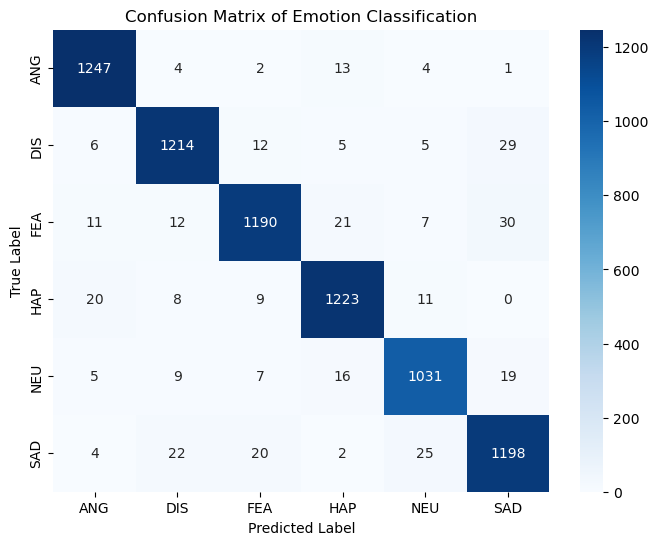

In [11]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()